In [1]:
import math
import numpy as np
from numpy.random import *
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import matplotlib
import enum
import itertools
from functools import * 
from matplotlib import animation, rc
from IPython.display import HTML

In [76]:
#ABM

S = 0
I = 1
R = 2


class Agent:
    def __init__(self, width, height, state):
        self.x = random()*width
        self.y = random()*height
        self.x0 = self.x
        self.y0 = self.y
        self.state = state
        
    def __repr__(self):
        return repr((self.x, self.y, self.state))
    
    
def dist(a1,a2):
    return np.linalg.norm([a1.x - a2.x, a1.y - a2.y])


def plot_sir(s,i,r, legend=["S", "I", "R"]):
    T = np.size(s)
    plt.plot(range(T), s)
    plt.plot(range(T), i)
    plt.plot(range(T), r)
    plt.legend(legend)

#sigma for diffusion, ci contact intensity, function of distance
class ABM: 

    def __init__(self, n, I0, l, theta, mu, ci, mobility="Ornstein_Uhlenbeck", **mobility_params):
        self.n = n
        self.I0 = I0
        self.agents = [Agent(l,l, S if i >= I0 else I) for i in range(n)]
        self.n_I = I0
        self.n_S = n - I0
        self.n_R = 0
        self.s = [self.n_S/n]
        self.i = [self.n_I/n]
        self.r = [self.n_R/n]
        self.theta = theta
        self.mu = mu
        self.ci = ci
        self.side = l
        self.total_time = 0
        self.time = 0
        self.iter_count = 0
        self.mobility = mobility
        self.mobility_params=mobility_params
        self.update_pos = getattr(self, mobility, lambda **mobility_params: self.Ornstein_Uhlenbeck(**mobility_params))(**mobility_params)

        
    def restart(self):
        self.agents = [Agent(l,l, S if i >= I0 else I) for i in range(n)]
        self.n_I = I0
        self.n_S = n - I0
        self.n_R = 0
        self.s.append(self.n_S/n)
        self.i.append(self.n_I/n)
        self.r.append(self.n_R/n)
        self.total_time +=1
        self.time = 0
        self.iter_count += 1
        
        
    def get_pos(self, state=None):
        if state == None:
            return np.array([[a.x, a.y] for a in self.agents])
        else:
            return np.array([[a.x, a.y] for a in self.agents if a.state == state])
    

    def update_counts(self, nI_change, nR_change):
        self.n_I += nI_change - nR_change
        self.n_S -= nI_change
        self.n_R += nR_change
    
    def update_state(self):
        for a in self.agents:
            if a.state == S:
                total_ci = reduce(lambda p_sum, a1: p_sum + (self.ci(a,a1) if a1.state == I and a1 != a else 0), self.agents, 0)
                if random() < 1 - np.exp(-total_ci*self.theta):
                    a.state = I
                    self.update_counts(1, 0)
            elif a.state == I:
                if random() < 1 - np.exp(-self.mu):
                    a.state = R
                    self.update_counts(0, 1)
    
    def update(self):
        self.update_state()
        self.update_pos()
        self.s.append(self.n_S/n)
        self.i.append(self.n_I/n)
        self.r.append(self.n_R/n)
        self.time += 1
        self.total_time += 1
    
    def Ornstein_Uhlenbeck(self, sigma=1, mean_reversion=0): #Brownian Motion if self.mean_reversion == 0
        def real_Ornstein_Uhlenbeck():
            for a in self.agents:
                a.x = (a.x + (mean_reversion*(a.x0 - a.x) + normal(0, sigma))) % self.side
                a.y = (a.y + (mean_reversion*(a.y0 - a.y) + normal(0, sigma))) % self.side
        return real_Ornstein_Uhlenbeck
                
    def day_cycle_mobility(self, sigma=1, mean_reversion=0, period=2):
        def real_day_cycle_mobility():
            if ((self.time % period) != 0):
                for a in self.agents:
                    a.x = (a.x + (mean_reversion*(a.x0 - a.x) + normal(0, sigma))) % self.side
                    a.y = (a.y + (mean_reversion*(a.y0 - a.y) + normal(0, sigma))) % self.side
        return real_day_cycle_mobility

    def sim(self, T):
        t_init = self.total_time
        for t in range(T-1):
            self.update()
        return self.s[t_init:],self.i[t_init:],self.r[t_init:]



In [72]:
def run_experiment(abm, T, iterations, beta=None):
    s0,i0,r0 = np.zeros(T), np.zeros(T), np.zeros(T)
    s,i,r = np.zeros(T), np.zeros(T), np.zeros(T)
    if beta is None:
        beta = compute_beta(abm.n,abm.side,abm.theta)
    
    for t in range(iterations):
        s_temp, i_temp, r_temp = abm.sim(T)
        abm.restart()
        s0 += np.array(s_temp)/iterations
        i0 += np.array(i_temp)/iterations
        r0 += np.array(r_temp)/iterations

    i[0] = I0/n
    s[0] = 1 - i[0]
    r[0] = 0

    for t in range(T-1):
        i[t+1] = i[t] + beta*s[t]*i[t] - abm.mu*i[t]
        r[t+1] =  r[t] + abm.mu*i[t]
        s[t+1] = 1 - r[t] - i[t]
        
    return abm, s, i, r, s0, i0, r0, T, beta

    
def print_experiment(abm, s, i, r, s0, i0, r0, T, beta):
    mobility_params_str = ", ".join(
        f"{param}: {value}"
        for param, value in abm.mobility_params.items()
    )
    print("Simulation with n: {}, l: {}, I0: {}, theta: {}, mu: {}, T: {}, for {} iterations\nMobility process: {}, with parameters {}".format(
                                                abm.n,abm.side,abm.I0, abm.theta, abm.mu, T, abm.iter_count, abm.mobility, mobility_params_str))
    print("The computed beta for the ODE is: {}".format(round(beta,3)))
    print("The average error across s,i,r is: {}".format(round(sum((i0 - i)**2 + (s0 - s)**2 + (r0 - r)**2)/(3*T),5)))
    plot_sir(s0,i0,r0)
    plot_sir(s, i, r, legend=["S_ABM", "I_ABM", "R_ABM","S_ODE", "I_ODE", "R_ODE"])
    plt.show()
    
def compute_beta(n, l, theta):
    integral = integrate.nquad(lambda x,y: np.exp(-0.005*(x-y)*(x-y)), [[0, l], [0, l]])[0]
    return n*theta*(integral**2)/(l**4)

ci = lambda a1,a2: np.exp(-0.005*((a1.x - a2.x)**2 + (a1.y - a2.y)**2))

In [64]:
class Test:
    def __init__(self, fun, **params):
         self.fun = getattr(self, fun)(**params)
         self.what = 3

    def fun1(self, *, enne):
        def realfun1():
            print(enne)
            print(self.what)
        return realfun1

t = Test("fun1", enne=2)
t.fun()


2
3


# Parameters

$n$ is the number of agents, $l$ the side of the box, $I_0$ the initial number of infected agents, $T$ the simulation seps, $\theta$ is an agent-to-agent infection rate (to be multiplied by a contact intensity which takes into account distance), $\mu$ is the ricovery rate, $ci$ is the contact intensity, function of the positions of the two agents, and $\sigma$ is standard-deviation of the diffusion process.

To be precise, the infection rate for agent $A \in S$ is $\theta\sum_{B \in I}ci(x_A, x_B)$, where $x_A$, $x_B$ are the positions of agent $A$ and $B$

For the ODE, $\mu$ is the same and the infection rate is $\beta$, computed from the ABM by averaging, as in the calibration document

The contact intensity function I am using is always $ci(x,y) = e^{-\lambda(x-y)^2}$ for some constant $\lambda$, because integrating it is very fast and it's an intuitively sensible contact intensity, at least qualitatively.

# Computations:

In the following cells we explore some aspects of the parameter space, starting with the impact of $\sigma$ and $n$.
As a measure of the goodness of the ODE approximation, we compute the total error defined as the $L_2$ distance $|| (S_{ABM}, I_{ABM}, R_{ABM}) - (S_{ODE}, I_{ODE}, R_{ODE})||_2$, where $(S_{ABM}, I_{ABM}, R_{ABM})$ is average across the specified number of iterations (here it's 50)

# Varying $\sigma$

Here we choose $n = 50, l = 100, I_0 = 2, \theta = 0.01, \mu = 0.05,  ci(x,y) = e^{-\lambda(x-y)^2}$ and vary $\sigma$ to be 0, 1, 5 or 50, and we repeat the experiment in the following cell with $n = 100$, and with $n = 300$ in the cell after that.

As expected, the same ABM model produces vastly different results when varying the timescale of mobility (which in this case is a simple diffusion, controlled by $\sigma$). The computation of $\beta$ does not reflect this, because it completely ignores the mobility process and just does a spatial average that does not include any time component, and thus the ODE results are identical regardless of $\sigma$. 

The ODE results tend to approximate the ABM results better and better for increasing $\sigma$, but in general they overestimate the speed of the infection, i.e. we mostly observe $I_{ODE} > I_{ABM}$. This is probably due to the fact that, when the diffusion is slow, clusters of infected agents form in the ABM, and the overall infection rate is then lower than for a well-mixed distribution of infected agents, because agents in the cluster cannot infect each other. For high $\sigma$, the correlation between neighboring agents' states is small, and this effect less impactful (the mean field assumption becomes justified)



Simulation with n: 50, l: 100, I0: 2, theta: 0.01, mu: 0.005, sigma: 0, T: 500, mean_reversion: 0, mobility process: Ornstein_Uhlenbeck, for 11 iterations
The computed beta for the ODE is: 0.027
The average error across s,i,r is: 0.09759


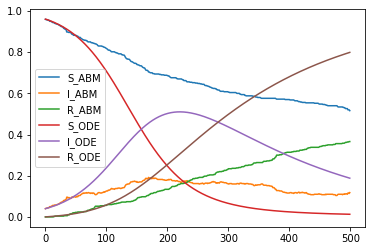

Simulation with n: 50, l: 100, I0: 2, theta: 0.01, mu: 0.005, sigma: 1, T: 500, mean_reversion: 0, mobility process: Ornstein_Uhlenbeck, for 11 iterations
The computed beta for the ODE is: 0.027
The average error across s,i,r is: 0.02871


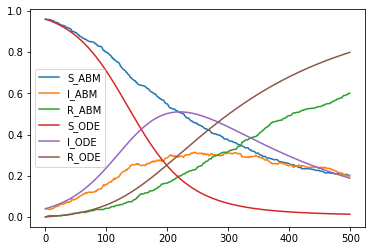

Simulation with n: 50, l: 100, I0: 2, theta: 0.01, mu: 0.005, sigma: 5, T: 500, mean_reversion: 0, mobility process: Ornstein_Uhlenbeck, for 11 iterations
The computed beta for the ODE is: 0.027
The average error across s,i,r is: 0.01729


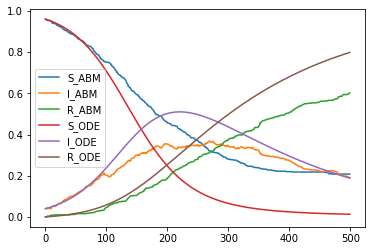

Simulation with n: 50, l: 100, I0: 2, theta: 0.01, mu: 0.005, sigma: 50, T: 500, mean_reversion: 0, mobility process: Ornstein_Uhlenbeck, for 11 iterations
The computed beta for the ODE is: 0.027
The average error across s,i,r is: 0.00145


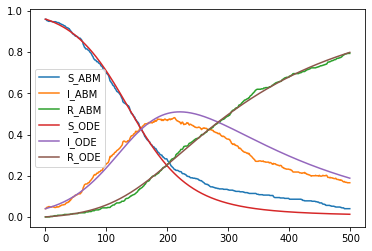

In [55]:
#n = 50 varying sigma
n = 50

l = 100
I0 = 2
T = 500
theta = 0.01
mu = 0.005
sigmas = [0, 1, 5, 50]
beta = compute_beta(n,l,theta)
for sigma in sigmas:
    abm = ABM(n, I0, l, theta, mu, sigma, ci)
    print_experiment(*run_experiment(abm, T, iterations,beta))

Simulation with n: 100, l: 100, I0: 2, theta: 0.01, mu: 0.005, sigma: 0, T: 500
The computed beta for the ODE is: 0.053
The average error across s,i,r over 10 iterations is: 0.02646


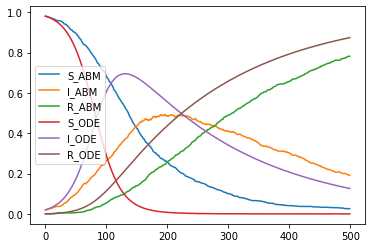

Simulation with n: 100, l: 100, I0: 2, theta: 0.01, mu: 0.005, sigma: 1, T: 500
The computed beta for the ODE is: 0.053
The average error across s,i,r over 10 iterations is: 0.0125


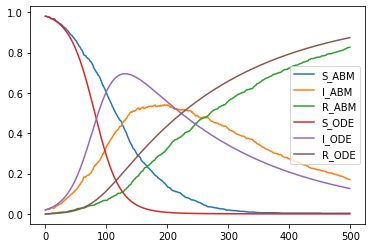

Simulation with n: 100, l: 100, I0: 2, theta: 0.01, mu: 0.005, sigma: 5, T: 500
The computed beta for the ODE is: 0.053
The average error across s,i,r over 10 iterations is: 0.00104


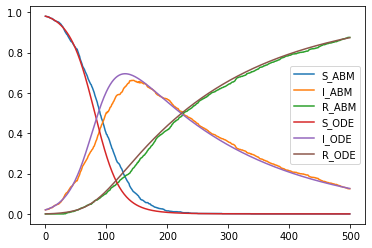

Simulation with n: 100, l: 100, I0: 2, theta: 0.01, mu: 0.005, sigma: 50, T: 500
The computed beta for the ODE is: 0.053
The average error across s,i,r over 10 iterations is: 0.00287


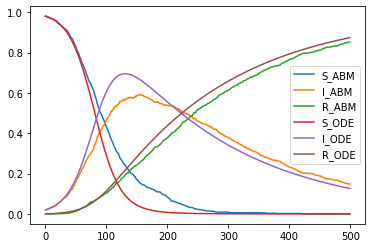

In [96]:
#n = 100, varying sigma
n = 100
beta = compute_beta(n,l,theta)
for sigma in sigmas:
    abm = ABM(n, I0, l, theta, mu, sigma, ci)
    print_experiment(*run_experiment(abm, T, iterations,beta))

Simulation with n: 300, l: 100, I0: 2, theta: 0.01, mu: 0.005, sigma: 0, T: 500
The computed beta for the ODE is: 0.16
The average error across s,i,r over 10 iterations is: 0.00669


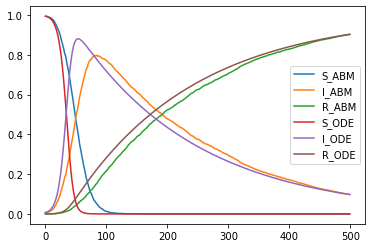

Simulation with n: 300, l: 100, I0: 2, theta: 0.01, mu: 0.005, sigma: 1, T: 500
The computed beta for the ODE is: 0.16
The average error across s,i,r over 10 iterations is: 0.00257


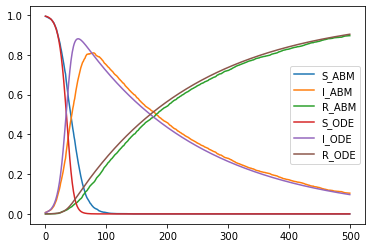

Simulation with n: 300, l: 100, I0: 2, theta: 0.01, mu: 0.005, sigma: 5, T: 500
The computed beta for the ODE is: 0.16
The average error across s,i,r over 10 iterations is: 0.0001


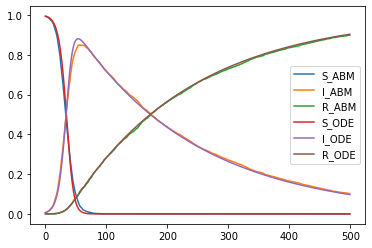

Simulation with n: 300, l: 100, I0: 2, theta: 0.01, mu: 0.005, sigma: 50, T: 500
The computed beta for the ODE is: 0.16
The average error across s,i,r over 10 iterations is: 0.00018


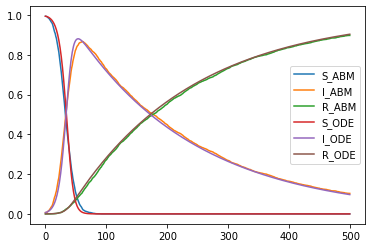

In [97]:
#n = 300, varying sigma
n = 300
beta = compute_beta(n,l,theta)
for sigma in sigmas:
    print_experiment(*run_experiment(abm, T, iterations,beta))

We now do this more systematically, by plotting the error as a function of $\sigma$ for many values of $n$

In [ ]:
# Running simulations and calculating error

ns = [j*50 for j in range(1, 10)]
error = np.zeros((len(ns), len(sigmas)))
T = 500
iterations = 10
for counter1, sigma in enumerate(sigmas):
    for counter, n in enumerate(ns):
        beta = compute_beta(n,l,theta)
        _, s, i, r, s0, i0, r0, _, _ = run_experiment(abm, T, iterations, beta)
        error[counter, counter1] = sum((i0 - i)**2 + (s0 - s)**2 + (r0 - r)**2)/(3*T)


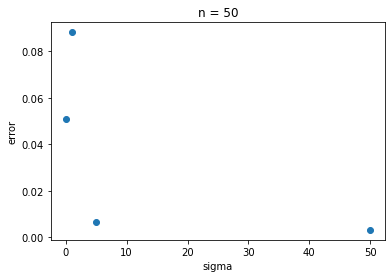

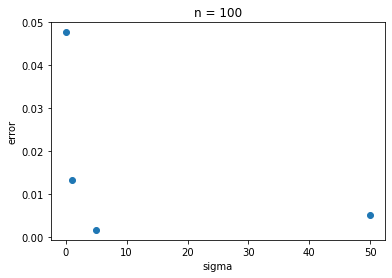

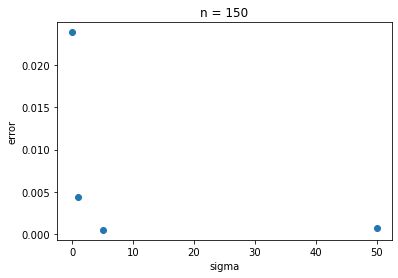

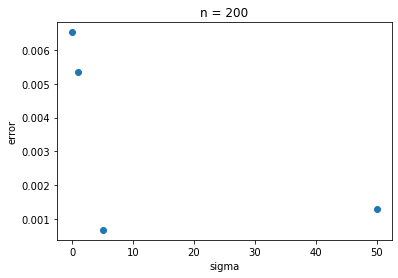

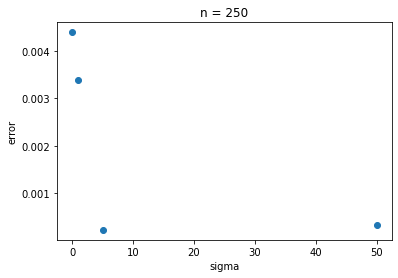

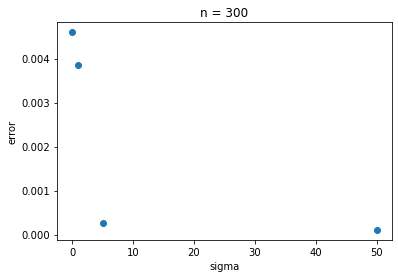

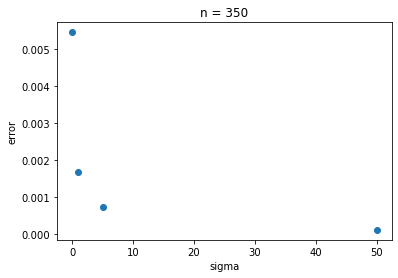

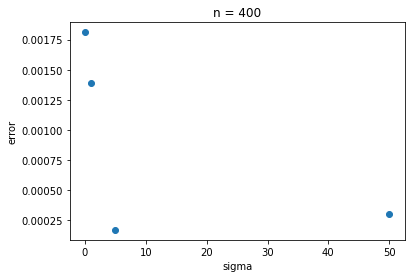

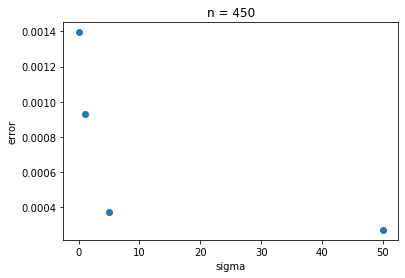

In [94]:
# Plotting error as a function of sigma for each n

for counter, n in enumerate(ns):
    plt.figure()
    plt.scatter(sigmas, error[counter, :])
    plt.xlabel("sigma")yt
    plt.ylabel("error")
    plt.title("n = {}".format(n))
    plt.show()

# Varying n

Here we reuse the results of the previous experiments, plotting this time the error for fixed $\sigma$ and varying $n$

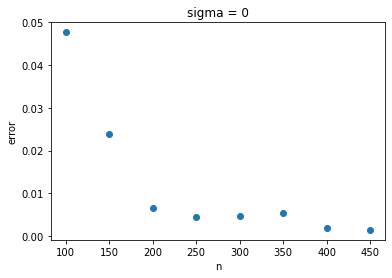

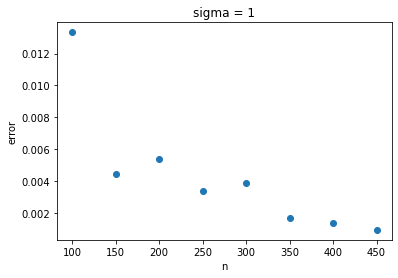

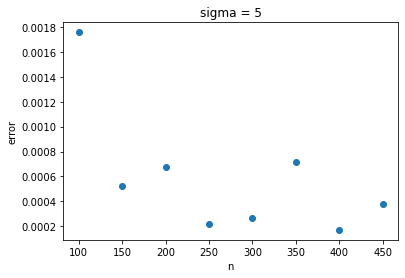

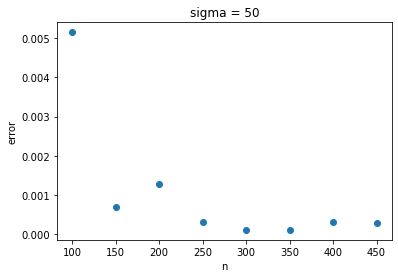

In [102]:
for counter, sigma in enumerate(sigmas):
    plt.figure()
    plt.title("sigma = {}".format(sigma))
    plt.scatter(ns[1:], error[1:, counter])
    plt.xlabel("n")
    plt.ylabel("error")
    plt.show()

# Changing the mobility process

Here we try to investigate the changes caused by not using a Brownian Motion as the mobility process. We now use an Ornstein Uhlenbeck process, a mean reverting process, where the mean for each agent is the randomly generated first initial position. Each agent thus tends to wander away from their initial position, but also to always pull back to it. 

The behavior of the mobility process is governed by the usual diffusion parameter $\sigma$, and by what's called "mean_reversion" in the code. Calling the latter parameter $\gamma$, the SDE satisfied by the position $x_t$ of an agent is:

$dx_t = \gamma(x_0 - x_t)dt+ \sigma dB_t$


In the animation, mean reversion can be observed by setting $\gamma$ to be nonzero and identifying some agents to observe, by setting $special$ to be equal to some nonempty list of indices of agents to observe (ex. special = [0]). The agents to observe appear in blue and are bigger.

Simulation with n: 50, l: 100, I0: 2, theta: 0.01, mu: 0.005, T: 500, for 10 iterations
Mobility process: Ornstein_Uhlenbeck, with parameters sigma: 5, mean_reversion: 0
The computed beta for the ODE is: 0.027
The average error across s,i,r is: 0.01007


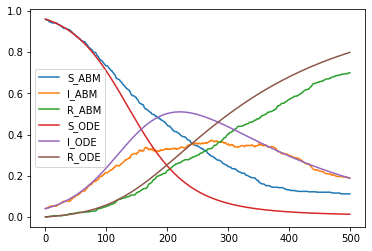

Simulation with n: 50, l: 100, I0: 2, theta: 0.01, mu: 0.005, T: 500, for 10 iterations
Mobility process: Ornstein_Uhlenbeck, with parameters sigma: 5, mean_reversion: 0.1
The computed beta for the ODE is: 0.027
The average error across s,i,r is: 0.00066


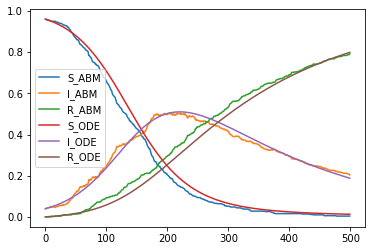

Simulation with n: 50, l: 100, I0: 2, theta: 0.01, mu: 0.005, T: 500, for 10 iterations
Mobility process: Ornstein_Uhlenbeck, with parameters sigma: 5, mean_reversion: 0.5
The computed beta for the ODE is: 0.027
The average error across s,i,r is: 0.03009


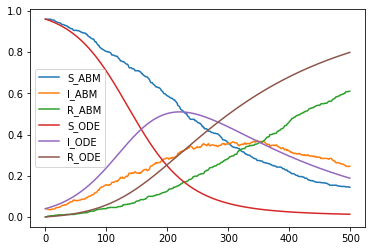

Simulation with n: 50, l: 100, I0: 2, theta: 0.01, mu: 0.005, T: 500, for 10 iterations
Mobility process: Ornstein_Uhlenbeck, with parameters sigma: 5, mean_reversion: 1
The computed beta for the ODE is: 0.027
The average error across s,i,r is: 0.00763


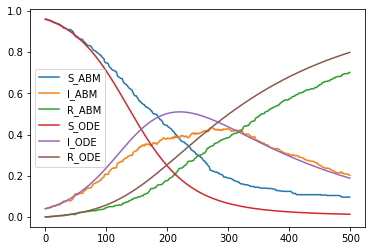

Simulation with n: 50, l: 100, I0: 2, theta: 0.01, mu: 0.005, T: 500, for 10 iterations
Mobility process: Ornstein_Uhlenbeck, with parameters sigma: 5, mean_reversion: 2
The computed beta for the ODE is: 0.027
The average error across s,i,r is: 0.00077


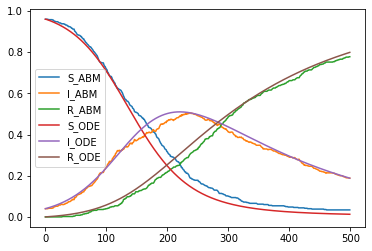

Simulation with n: 50, l: 100, I0: 2, theta: 0.01, mu: 0.005, T: 500, for 10 iterations
Mobility process: Ornstein_Uhlenbeck, with parameters sigma: 5, mean_reversion: 5
The computed beta for the ODE is: 0.027
The average error across s,i,r is: 0.00094


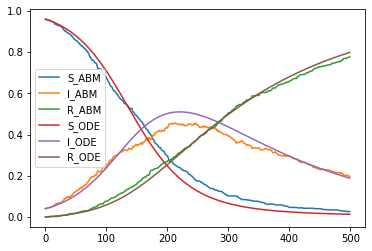

In [78]:
n = 50
l = 100
I0 = 2
T = 500
theta = 0.01
mu = 0.005
iterations = 10
sigma = 5
gammas = [0, 0.1, 0.5, 1, 2, 5]
beta = compute_beta(n,l,theta)
for gamma in gammas:
    abm = ABM(n, I0, l, theta, mu, ci, sigma=sigma, mean_reversion=gamma)
    print_experiment(*run_experiment(abm, T, iterations,beta))

# More complicated mobility processes:

Time dependent: we start with a very simply process, a diffussion that periodically stops for a time step. Initially the period if set to 2, so the process just alternates between diffusion and standstill

Agent dependent: depending on other agents, like repulsion or attraction or a combination

Simulation with n: 100, l: 100, I0: 2, theta: 0.01, mu: 0.005, T: 500, for 50 iterations
Mobility process: day_cycle_mobility, with parameters sigma: 5, period: 2
The computed beta for the ODE is: 0.053
The average error across s,i,r is: 0.00284


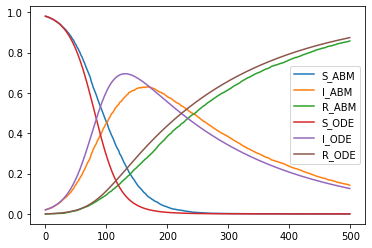

Simulation with n: 100, l: 100, I0: 2, theta: 0.01, mu: 0.005, T: 500, for 50 iterations
Mobility process: day_cycle_mobility, with parameters sigma: 5, period: 4
The computed beta for the ODE is: 0.053
The average error across s,i,r is: 0.0002


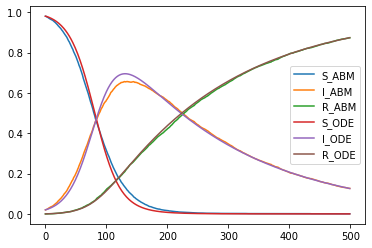

Simulation with n: 100, l: 100, I0: 2, theta: 0.01, mu: 0.005, T: 500, for 50 iterations
Mobility process: day_cycle_mobility, with parameters sigma: 5, period: 8
The computed beta for the ODE is: 0.053
The average error across s,i,r is: 0.00122


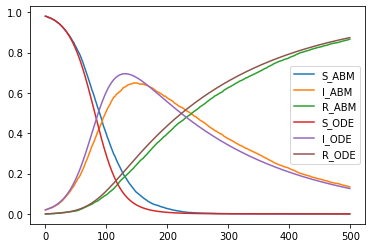

Simulation with n: 100, l: 100, I0: 2, theta: 0.01, mu: 0.005, T: 500, for 50 iterations
Mobility process: day_cycle_mobility, with parameters sigma: 5, period: 16
The computed beta for the ODE is: 0.053
The average error across s,i,r is: 0.00099


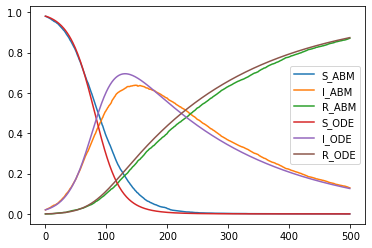

In [ ]:
n = 100
l = 100
I0 = 2
T = 500
theta = 0.01
mu = 0.005
iterations = 50
sigma = 5
abm = ABM(n, I0, l, theta, mu, ci, sigma=sigma)
abm1 = ABM(n, I0, l, theta, mu, ci, mobility="day_cycle_mobility", sigma=sigma, period = 2)
abm2 = ABM(n, I0, l, theta, mu, ci, mobility="day_cycle_mobility", sigma=sigma, period = 4)
abm3 = ABM(n, I0, l, theta, mu, ci, mobility="day_cycle_mobility", sigma=sigma, period = 8)
abm4 = ABM(n, I0, l, theta, mu, ci, mobility="day_cycle_mobility", sigma=sigma, period = 16)
abm5 = ABM(n, I0, l, theta, mu, ci, mobility="day_cycle_mobility", sigma=sigma, period = 32)
print_experiment(*run_experiment(abm1, T, iterations))
print_experiment(*run_experiment(abm2, T, iterations))
print_experiment(*run_experiment(abm3, T, iterations))
print_experiment(*run_experiment(abm4, T, iterations))
print_experiment(*run_experiment(abm5, T, iterations))
print_experiment(*run_experiment(abm, T, iterations))

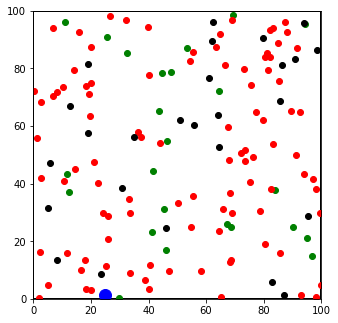

In [63]:
%matplotlib inline
sigma = 5
n = 150
l = 100
special = [0] # SET THIS TO [0], or some nonempty list of agent indices, to observe specific agents (in blue),
gamma = 1  #  ex. to observe mean reversion set special = [0] and gamma = 1 (or some other nonzero value)
I0 = 2
T = 100
theta = 0.01
mu = 0.005
ci = lambda a1,a2: np.exp(-0.005*((a1.x - a2.x)**2 + (a1.y - a2.y)**2))
mobility = "day_cycle_mobility"

abm = ABM(n, I0, l, theta, mu, sigma, ci, mean_reversion=gamma, mobility=mobility, period=32)
fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(0, l), ylim=(0, l))

agents_S, = ax.plot([], [], 'go', ms=6)
agents_I, = ax.plot([], [], 'ro', ms=6)
agents_R, = ax.plot([], [], 'ko', ms = 6)
agents_special, = ax.plot([], [], 'bo', ms = 12)

# rect is the box edge
rect = plt.Rectangle([0,0],l, l,
                     ec='none', lw=2, fc='none')
ax.add_patch(rect)

def init():
    """initialize animation"""
    global rect
    agents_S.set_data([], [])
    agents_I.set_data([], [])
    agents_R.set_data([], [])
    rect.set_edgecolor('none')
    return agents_S, agents_I, agents_R, rect

def animate(i):
    """perform animation step"""
    global abm, rect, ax, fig
    abm.update()
    
    # update pieces of the animation
    rect.set_edgecolor('k')
    pos_S = abm.get_pos(S)
    pos_I = abm.get_pos(I)
    pos_R = abm.get_pos(R)
    pos_special = np.zeros((len(special), 2))
    if pos_S.size > 0:
        agents_S.set_data(pos_S[:, 0], pos_S[:, 1])
    else:
        agents_S.set_data([], [])
    if pos_I.size > 0:
        agents_I.set_data(pos_I[:, 0], pos_I[:, 1])
    else:
        agents_I.set_data([], [])
    if pos_R.size > 0:
        agents_R.set_data(pos_R[:, 0], pos_R[:, 1])
    else:
        agents_R.set_data([], [])
    for i in special:
        a = abm.agents[i]
        pos_special[i, 0] = a.x
        pos_special[i, 1] = a.y
    agents_special.set_data(pos_special[:, 0], pos_special[:, 1])
    return agents_S, agents_I, agents_R, rect

anim = animation.FuncAnimation(fig, animate, frames=T,
                              interval=500, blit=True, init_func=init)


rc('animation', html='html5')
anim
